# Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/ImageCaptioning

Mounted at /content/drive
/content/drive/MyDrive/ImageCaptioning


In [2]:
import re
import cv2
import math
import glob
import spacy
import random
import numpy as np
import pandas as pd
from time import time
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction


import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.models import resnet50, ResNet50_Weights
from torch.nn import TransformerDecoder, TransformerDecoderLayer, TransformerEncoder, TransformerEncoderLayer



device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [3]:
!python -m spacy download en_core_web_sm
!pip install tensorboard

2024-01-29 08:40:06.864045: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-29 08:40:06.864105: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-29 08:40:06.865255: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-29 08:40:07.876511: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 33.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Dataset

In [4]:
spacy_eng = spacy.load("en_core_web_sm")

In [5]:
class Vocabulary:
    def __init__(self,freq_threshold):
        # Setting the pre-reserved tokens int to string tokens
        self.index2word = {0:"<PAD>", 1:"<SOS>", 2:"<EOS>", 3:"<UNK>"}

        # String to int tokens
        # Tts reverse dict self.index2word
        self.word2index = {v: k for k, v in self.index2word.items()}

        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.index2word)

    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]

    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1

                #add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == self.freq_threshold:
                    self.word2index[word] = idx
                    self.index2word[idx] = word
                    idx += 1

    def numericalize(self,text):
        """ For each word in the text corresponding index token for that word form the vocab built as list """
        tokenized_text = self.tokenize(text)
        return [self.word2index[token] if token in self.word2index else self.word2index["<UNK>"] for token in tokenized_text ]

In [6]:
class ImageCaptioningDataset(Dataset):
    """Image Captioning dataset"""

    def __init__(self, csv_file, transform, max_length, freq_threshold=5):
        self.dataframe = pd.read_csv(csv_file)
        self.transform = transform
        self.max_length = max_length

        self.images = self.dataframe['image']
        self.captions = self.dataframe['caption']

        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())


    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        caption = self.captions[idx]
        image_path = self.images[idx]

        image = cv2.imread(f'dataset/Images/{image_path}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        # Tokenize caption
        caption_tokens = []
        caption_tokens += [self.vocab.word2index["<SOS>"]]
        caption_tokens += self.vocab.numericalize(caption)
        caption_tokens += [self.vocab.word2index["<EOS>"]]

        input_tokens = caption_tokens[:-1].copy() # input
        target_tokens = caption_tokens[1:].copy() # target

        # Padding input tokens
        cap_length = len(input_tokens)
        padding_size = self.max_length - cap_length
        input_tokens += [0] * padding_size
        target_tokens += [0] * padding_size


        # Create padding mask
        padding_mask = torch.ones([self.max_length, ])
        padding_mask[:cap_length] = 0.0
        padding_mask = padding_mask.bool()

        input_tokens = torch.tensor(input_tokens) # input
        target_tokens = torch.tensor(target_tokens) # target

        return image, input_tokens, target_tokens, padding_mask

# Model

## Encoder

In [7]:
class Encoder(torch.nn.Module):
    def __init__(self, encoder_dim, d_model):
        super(Encoder, self).__init__()

        # Load pretrained model and remove last fc layer
        pretrained_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.model = torch.nn.Sequential(*list(pretrained_model.children())[:-2]).to(device)

        # Freeze layer
        for param in self.model.parameters():
            param.requires_grad = False

        self.linear = torch.nn.Linear(encoder_dim, d_model).to(device)
    def forward(self, images):
        images = images.to(device)

        features = self.model(images)
        features = features.view(features.size(0), features.size(1), -1)
        features = features.permute(0, 2, 1)
        features = self.linear(features)
        return features # (batch_size, 49, d_model)

## PositionalEncoding


In [8]:
class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model, dropout = 0.1, max_len = 50):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        self.pe = torch.zeros(1, max_len, d_model).to(device)
        self.pe[0, :, 0::2] = torch.sin(position * div_term)
        self.pe[0, :, 1::2] = torch.cos(position * div_term)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


## Decoder

In [9]:
class Decoder(torch.nn.Module):

    def __init__(self, n_tokens, d_model,
                 n_heads, dim_forward,
                 n_layers, dropout = 0.2):
        super(Decoder, self).__init__()
        self.embedding = torch.nn.Embedding(n_tokens, d_model).to(device) # embedding layer
        self.pos_encoder = PositionalEncoding(d_model, dropout).to(device) # positional encoder

        decoder_layers = TransformerDecoderLayer(d_model, n_heads, dim_forward, dropout, batch_first=True) # encoder layer
        self.transformer_decoder = TransformerDecoder(decoder_layers, n_layers).to(device) # transformer encoder


        self.d_model = d_model # number of features
        self.linear = torch.nn.Linear(d_model, n_tokens).to(device) # last linear model for prediction

    def forward(self, features, captions, padding_mask, captions_mask = None):
        """
        Arguments:
            captions: Tensor, shape ``[batch_size, seq_len]``
            captions_mask: Tensor, shape ``[seq_len, seq_len]``

        Returns:
            output Tensor of shape ``[batch_size, seq_len, n_tokens]``
        """
        captions = captions.to(device)
        captions = self.embedding(captions)
        captions = captions * math.sqrt(self.d_model)
        captions = self.pos_encoder(captions)

        if captions_mask is None:
            """Generate a square causal mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
            """
            captions_mask = torch.nn.Transformer.generate_square_subsequent_mask(captions.size(1)).to(device)

        output = self.transformer_decoder(tgt=captions,
                                          memory=features,
                                          tgt_key_padding_mask=padding_mask,
                                          tgt_mask=captions_mask)
        output = self.linear(output)
        return output


    def predict(self, feature, max_length, vocab):
        word = torch.tensor([vocab.word2index['<SOS>']] + [0] * (max_length - 1)).view(1, -1).to(device)
        padding_mask = torch.Tensor([True] * max_length).view(1, -1).to(device)

        predicted_captions = []

        for i in range(max_length - 1):
            # Update the padding masks
            padding_mask[:, i] = False

            # Get the model prediction for the next word
            output = self.forward(feature, word, padding_mask)
            output = output[0, i]
            predicted_word_idx = output.argmax(dim=-1)
            predicted_captions.append(predicted_word_idx.item())
            word[:, i + 1] = predicted_word_idx.item()

            # End if <EOS> appears
            if vocab.index2word[predicted_word_idx.item()] == "<EOS>":
                break

        return ' '.join([vocab.index2word[idx] for idx in predicted_captions])

## Captioner

In [10]:
class Captioner(torch.nn.Module):
    def __init__(self, n_tokens, d_model, n_heads, dim_forward, n_layers, encoder_dim, vocab):
        super(Captioner, self).__init__()
        self.encoder =  Encoder(encoder_dim=encoder_dim,
                                d_model=d_model)
        self.decoder = Decoder(n_tokens=n_tokens,
                               d_model=d_model,
                               n_heads=n_heads,
                               dim_forward=dim_forward,
                               n_layers=n_layers)

        self.vocab = vocab

    def forward(self, images, captions, padding_mask):

        features = self.encoder(images)
        output = self.decoder(features, captions, padding_mask)

        return output

    def generate_caption(self, image, max_length=50):
        image = image.to(device)
        features = self.encoder(image)
        predicted_caption = self.decoder.predict(features, max_length, self.vocab)
        return predicted_caption

# Utils

In [11]:
def get_dataset_loader(batch_size, max_length):
    transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize(232, antialias=True),
                        transforms.CenterCrop(224),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225])])

    dataset = ImageCaptioningDataset(
                        csv_file=f"dataset/captions.txt",
                        transform=transform,
                        max_length=max_length)

    loader = DataLoader(
                    dataset=dataset,
                    batch_size=batch_size,
                    shuffle=True,
                    num_workers=2)

    return dataset, loader

# Train

## Trainer

In [12]:
class Trainer():
    def __init__(self):
        self.d_model = 300
        self.n_heads = 4
        self.dim_forward = 512
        self.n_layers = 1
        self.encoder_dim = 2048

        self.num_epochs = 100
        self.batch_size = 32
        self.learning_rate = 3e-3
        self.max_length = 50

        # Dataset
        self.dataset, self.loader = get_dataset_loader(self.batch_size, self.max_length)

        self.n_tokens = len(self.dataset.vocab)
        self.vocab = self.dataset.vocab

    def train(self, resume=False):
        # Init model, optimizer, criterion
        model = Captioner(
            n_tokens=self.n_tokens,
            d_model=self.d_model,
            n_heads=self.n_heads,
            dim_forward=self.dim_forward,
            n_layers=self.n_layers,
            encoder_dim=self.encoder_dim,
            vocab=self.vocab
        )
        criterion = torch.nn.CrossEntropyLoss(ignore_index=self.dataset.vocab.word2index["<PAD>"])
        optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)


        start_epoch = 0  # Starting epoch
        min_loss = 9999 # Min loss to determine it is the best model or not

        if resume:
            # Load model and optimizer state
            model_state, optimizer_state, prev_epoch, prev_loss = self.load_model()
            model.load_state_dict(model_state)
            optimizer.load_state_dict(optimizer_state)

            # Starting epoch
            start_epoch = prev_epoch
            min_loss = prev_loss

        for epoch in range(start_epoch + 1, self.num_epochs + 1):
            epoch_loss = []
            model.train()
            pbar = tqdm(enumerate(iter(self.loader)), position=0, leave=True)
            for idx, (images, captions, targets, padding_mask) in pbar:
                images, captions, targets, padding_mask = images.to(device), captions.to(device), targets.to(device), padding_mask.to(device)

                # Zero the gradients
                optimizer.zero_grad()

                # Forward
                outputs = model(images, captions, padding_mask)

                # Calculate the loss
                loss = criterion(outputs.view(-1, self.n_tokens), targets.reshape(-1))
                epoch_loss.append(loss.item())

                # Backward and update params
                loss.backward()
                optimizer.step()

                # Show progess bar
                pbar.set_postfix_str(f"Training loss: {sum(epoch_loss) / len(epoch_loss):0.4f}")
            # Compute average loss per epoch
            avg_epoch_loss = sum(epoch_loss) / len(epoch_loss)

            # Save model
            if avg_epoch_loss < min_loss:
                self.save_model(model, optimizer, epoch, avg_epoch_loss)

    def save_model(self, model, optimizer, epoch, loss):
        model_state = {
            'epoch': epoch,
            'loss': loss,
            'd_model': self.d_model,
            'n_tokens': self.n_tokens,
            'n_heads': self.n_heads,
            'dim_forward': self.dim_forward,
            'n_layers': self.n_layers,
            'encoder_dim': self.encoder_dim,
            'vocab': self.vocab,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }

        torch.save(model_state, f'models/transformer2/model_{epoch}_{loss:.4f}.pth')
        torch.save(model_state, f'models/transformer2/model_best.pth')


    def load_model(self):
        path = glob.glob("models/transformer2/*.pth")[-2]
        checkpoint = torch.load(path)

        epoch = checkpoint['epoch']
        loss = checkpoint['loss']

        model_state = checkpoint['model_state_dict']
        optimizer_state = checkpoint['optimizer_state_dict']

        return model_state, optimizer_state, epoch, loss

## Training

In [ ]:
trainer = Trainer()
trainer.train(resume=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 115MB/s]
0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
1265it [24:35,  1.17s/it, Training loss: 4.6760]
1265it [09:36,  2.20it/s, Training loss: 4.6896]
1265it [09:29,  2.22it/s, Training loss: 4.6906]
1265it [09:26,  2.23it/s, Training loss: 4.6620]
1265it [09:32,  2.21it/s, Training loss: 4.6719]
1265it [09:45,  2.16it/s, Training loss: 4.6658]
1265it [09:51,  2.14it/s, Training loss: 4.6478]
1265it [09:47,  2.15it/s, Training loss: 4.6614]
1265it [09:53,  2.13it/s, Training loss: 4.6581]
264it [02:05,  3.06it/s, Training loss: 4.6496]

# Test

In [ ]:
def load_model(path):
    checkpoint = torch.load(path)
    model = Captioner(
        n_tokens=checkpoint['n_tokens'],
        d_model=checkpoint['d_model'],
        n_heads=checkpoint['n_heads'],
        dim_forward=checkpoint['dim_forward'],
        n_layers=checkpoint['n_layers'],
        encoder_dim=checkpoint['encoder_dim'],
        vocab=checkpoint['vocab'],

    )
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

def plot_result(image, caption):
    plt.imshow(image)
    plt.axis("off")
    plt.title(caption)

In [ ]:
model = load_model("models/transformer2/model_best.pth")
model.eval()
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(232, antialias=True),
        transforms.CenterCrop(224),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
        ])
images = glob.glob("dataset/Images/*.jpg")
df = pd.read_csv('dataset/captions.txt')

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 74.4MB/s]


A crowd watches as two formula one cars leave the starting line .
A crowd watches the start of a drag race at twilight .
A group of people watch a drag race at the beginning and see the fire from the cars .
People look at the flames coming from the cars at a drag race .
The drag racers take off the starting line .


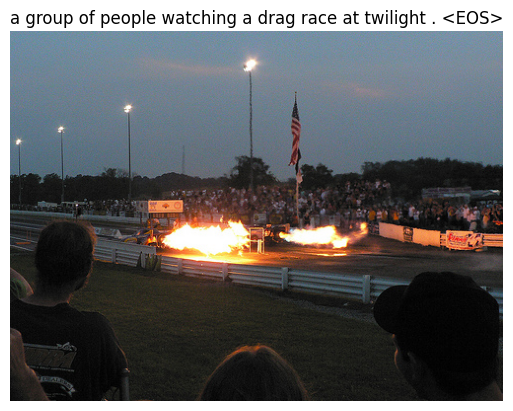

In [ ]:
with torch.no_grad():
    idx = random.randint(0, len(images))
    image_path = images[idx]
    name_path = image_path.split('/')[-1]
    labels = df[df['image'] == name_path]['caption']

    for key, value in labels.items():
        print(value)


    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image_input = transform(image).unsqueeze(0)
    caption = model.generate_caption(image_input)

    plot_result(image, caption)
